End-to-end multi class dog breed classification using TensorFlow 2.0 and TensorFlow HUb

## Problem
Identifyiing the breed of the dog given an image of a dog.

## Data
https://www.kaggle.com/c/dog-breed-identification/data

## Evaluation
Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

## Features
We're dealing with unstructured data. 
120 dog breeds
10,000+ images in training set
10,000+ images in test set


## Getting our workspace ready

In [45]:
import tensorflow as tf
print("TF version:",tf.__version__)

TF version: 2.2.0


In [46]:
import tensorflow_hub as hub
print("TF Hub version:",hub.__version__)

TF Hub version: 0.8.0


In [47]:
# check for GPU availability
print("GPU","available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


## Getting our data ready

In [48]:
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/dog-breed-identification/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     6f3ffaa96d2f7c365d40f71dcbca6336  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


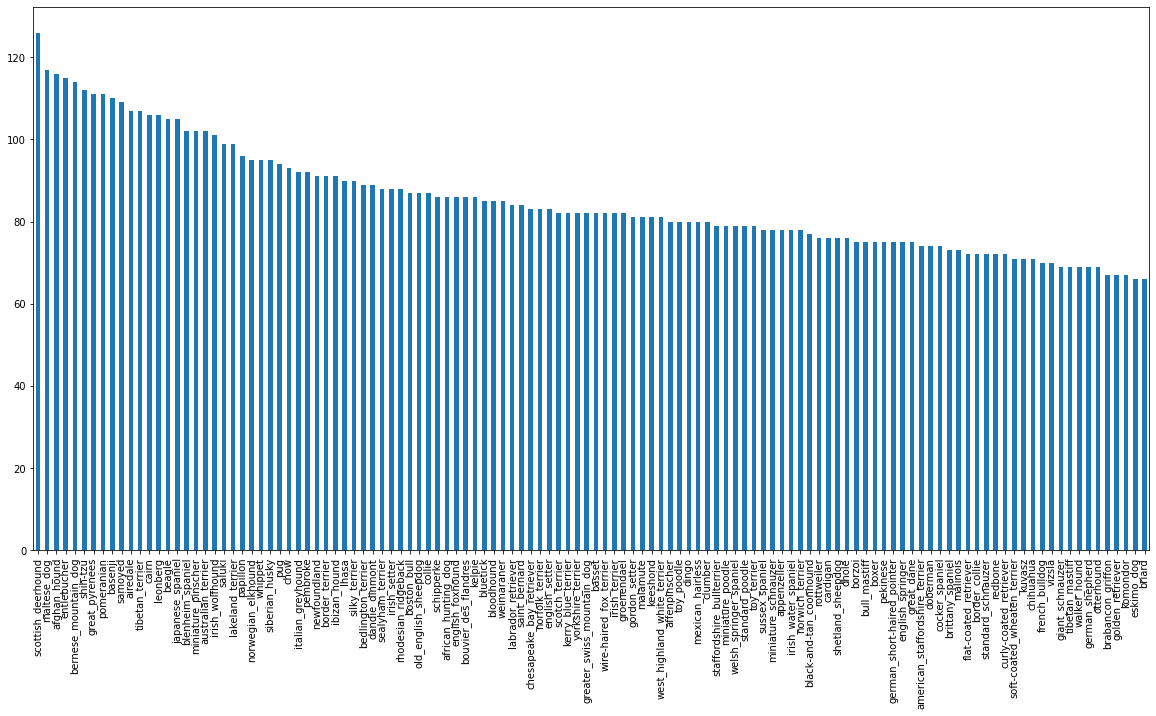

In [49]:
# How many images are there of each breeed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [50]:
labels_csv["breed"].value_counts().median() # there has to be more than 10 images per label

82.0

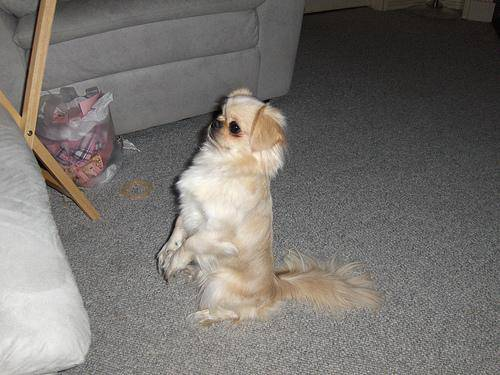

In [51]:
# viewing an image
from IPython.display import Image
Image("drive/My Drive/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg") 

## Getting images and their labels

In [52]:
filenames = ["drive/My Drive/dog-breed-identification/train/"+fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/My Drive/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [53]:
# checking whether the number of filename matches number of actual image files

import os
if len(os.listdir("drive/My Drive/dog-breed-identification/train/")) == len(filenames):
  print("Filenames match actual number of images")

Filenames match actual number of images


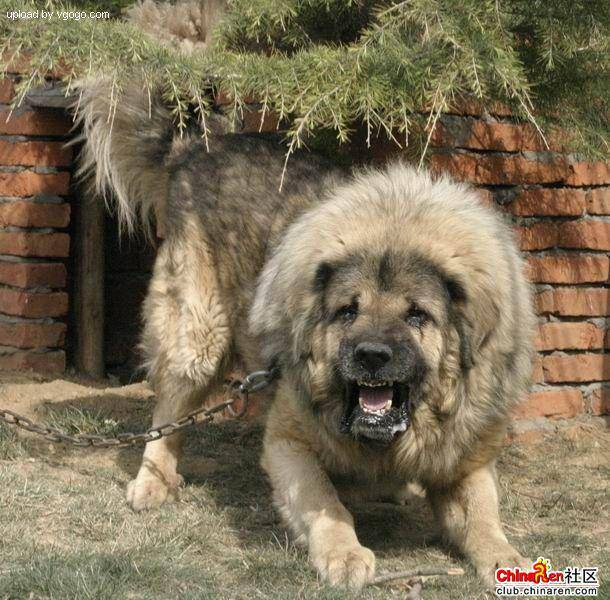

In [54]:
Image(filenames[9000])

In [55]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Preparing the labels

In [56]:
import numpy as np
labels = np.array(labels_csv["breed"])
labels 

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [57]:
# Checking if the number of labels matches the number of filenames
if len(labels)==len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match the number of filenames")

Number of labels matches number of filenames


In [58]:
# Find the unique labels
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [59]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [60]:
# Turn every label into a boolean array
boolean_labels = [label ==unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [61]:
# Example: Turning boolean array into inegers
print(labels[0])
print(np.where(unique_breeds==labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) #index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating a validation set

In [0]:
X = filenames
y = boolean_labels

Starting with 100 images

In [0]:
NUM_IMAGES = 1000 #@param {type:"slider",min:1000,step:1000,max:10000}

In [64]:
# splitting data
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=42)

len(X_train),len(y_train),len(X_val),len(y_val)

(800, 800, 200, 200)

In [65]:
X_train[:5],y_train[:5]

(['drive/My Drive/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/dog-breed-identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/dog-breed-identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/dog-breed-identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fals

## Preprocessing images (tensors)

In [66]:
# convert image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [67]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [68]:
# turn image into tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [0]:
# define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path,img_size = IMG_SIZE):
  """
  Takes an image file path and turns it into a tensor
  """
  # read an image file
  image = tf.io.read_file(image_path)

  # turn jpg to image tensor with 3 colour channels
  image = tf.image.decode_jpeg(image, channels=3)

  #convert the colour channel values from 0 - 255 to 0 - 1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  #resize
  image = tf.image.resize(image, size=(IMG_SIZE,IMG_SIZE))

  return image
  



## turning the data into batches
32 min in a batch - yunn lecun
because limited memory

data should be in the form of `(data,label)` to form a batch


In [0]:
# Create a simple function to return a tuple (image,label)
def get_image_label(image_path,label):
  """
  Takes an image file path name and associated lebel,
  processes the image and returns a tuple of (image,label).
  """
  image = process_image(image_path)
  return image,label

In [71]:
# demo of the above
get_image_label(X[42],y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [0]:
# define tne bartch size - 32
BATCH_SIZE = 32

#function to turn data into batches
def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  """
  Create batches of data out of image X and label y pairs
  Shuffles the data if its training data but not if it is validation data
  Also accepts test data as input (no labels).
  """

  # if the data is test dataset, then there are no labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only filepaths and no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  #if the data is a valid dataset, we dont need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("Creatin training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    #shuffling
    data = data.shuffle(buffer_size=len(X)) #easier to shuffle filenames rather than full images
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch


In [73]:
# create training nad validation data batches
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data=True)

Creatin training data batches...
Creating validation data batches...


In [74]:
#attributes of data batches
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

##visualising data batches

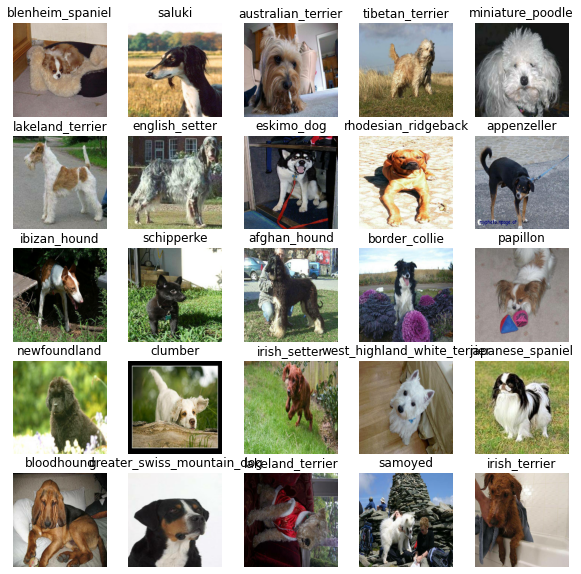

In [75]:
import matplotlib.pyplot as plt
def show_batch(images, labels):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(images[n])
      plt.title(unique_breeds[labels[n].argmax()])
      plt.axis('off')

train_images, train_labels = next(train_data.as_numpy_iterator())
show_batch(train_images, train_labels)

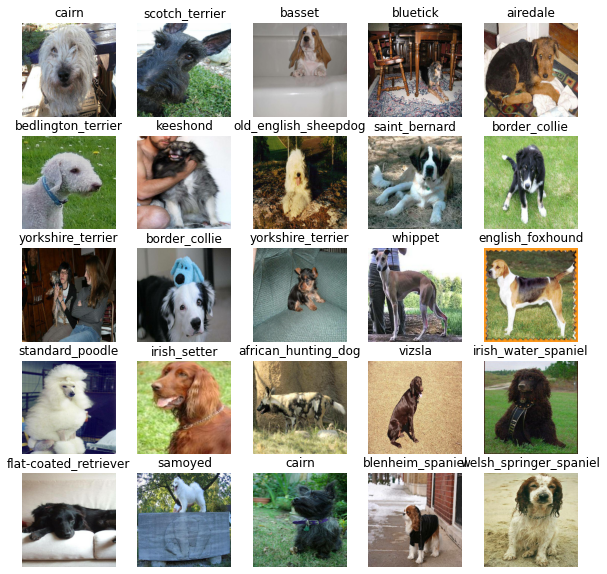

In [76]:
val_images,val_labels = next(val_data.as_numpy_iterator())
show_batch(val_images,val_labels)

## building a model
1. input shape
2. output shape
3. url of the model

In [0]:
# defining the input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch,height,width, colour channels

OUTPUT_SHAPE = len(unique_breeds)

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [0]:
# Defining the layers in a keras model in sequential fashion
#Creating a function which builds a keraas model
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print("Building model with:",MODEL_URL)

  #setup the model layers
  model = tf.keras.Sequential([
  hub.KerasLayer(MODEL_URL), # layer 1,input layer
  tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") #Layer 2, output layer 
  ])

  #complie the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
  #Build the model
  model.build(INPUT_SHAPE)

  return model

In [79]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks
Callbacks are helper functions that can be used during training to check its progress or stop training early

1. TensorBoard to track our model progress and for early stopping to prevent model from training for too long.


In [0]:
#load TenssorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

#create a function to build a tensorboard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog_vision/logs",
                        # Make it so that the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

## early stopping to prevent from overfitting


In [0]:
# eary stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  patience=3
)

## Training the model
This model is going to train on only 1000 samples to make sure verything is working

In [0]:
# epochs is the number of passes
NUM_EPOCHS = 100 #@param {type:"slider",min:10,max:100,step:10}

In [84]:
#Checking whether the GPU is working
print("GPU","available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


# Creating the model
1. Creating the model
2. Setup TensorBoard create_tensorboard_callback
3. call fit function
4. return the model

In [0]:
#Build a function
def train_model():
  """
  Trains the model and returns the trained model
  """
  # create a model
  model = create_model()

  #create new TensorBoard session everytime we train the model
  tensorboard = create_tensorboard_callback()

  #Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,epochs=NUM_EPOCHS,
            validation_data=val_data,validation_freq=1,
            callbacks=[tensorboard,early_stopping])    #validation frequency tells how often the patterns are tested on validation set
  
  return model

In [86]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 676s 27s/step - loss: 4.4284 - accuracy: 0.1112 - val_loss: 3.3364 - val_accuracy: 0.2400
Epoch 2/100
25/25 [==============================] - 4s 179ms/step - loss: 1.5526 - accuracy: 0.7000 - val_loss: 2.1765 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 4s 178ms/step - loss: 0.5473 - accuracy: 0.9400 - val_loss: 1.7019 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 4s 180ms/step - loss: 0.2471 - accuracy: 0.9862 - val_loss: 1.5356 - val_accuracy: 0.6250
Epoch 5/100
25/25 [==============================] - 4s 178ms/step - loss: 0.1464 - accuracy: 0.9975 - val_loss: 1.4628 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 4s 177ms/step - loss: 0.0995 - accuracy: 1.0000 - val_loss: 1.4228 - val_accuracy: 0.6550
Epoch 7/100
25/25 [==============================

# Checking tensorboard logs
The tensor board magic function will access the log directory and visulaise its contents

In [87]:
%tensorboard --logdir drive/My\ Drive/Dog_vision/logs

Output hidden; open in https://colab.research.google.com to view.

# Making and evaluating predictions using trained model

In [88]:
# making prediction on validation set (not used to train the model)
predictions = model.predict(val_data,verbose=1)
predictions

7/7 [==============================] - 1s 119ms/step


array([[8.63792142e-04, 6.61757949e-05, 5.36012754e-04, ...,
        6.72828523e-04, 4.32141242e-05, 1.41383545e-03],
       [1.77010661e-03, 1.00413614e-04, 1.12879584e-02, ...,
        4.35443129e-04, 1.56469445e-03, 6.17978512e-04],
       [5.40033852e-06, 1.16815914e-04, 4.05085266e-05, ...,
        3.32572454e-05, 7.86615419e-05, 1.42590012e-04],
       ...,
       [7.85896646e-06, 2.24594769e-05, 1.65191959e-04, ...,
        2.02575939e-05, 3.89319321e-05, 8.75372643e-06],
       [4.91972035e-03, 3.32443480e-04, 2.71060359e-04, ...,
        1.74617264e-04, 8.54416649e-05, 2.16261763e-02],
       [2.00828217e-04, 1.46477641e-05, 2.75003840e-04, ...,
        1.25320014e-02, 4.48665262e-04, 2.84794893e-04]], dtype=float32)

In [89]:
predictions.shape,len(y_val)

((200, 120), 200)

In [90]:
# first prediction
index = 42 
print(predictions[index])
print(f"max probability: {np.max(predictions[index])}")
print(f"sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]} ")

[4.41931625e-04 1.78654620e-04 9.54706557e-05 1.00697180e-04
 1.92183047e-03 5.14396270e-05 3.32657772e-04 2.53969803e-03
 2.60503180e-02 7.51686841e-02 2.51687525e-05 1.95817138e-05
 3.19652347e-04 1.04787434e-02 1.33077195e-03 5.89680625e-03
 3.09399111e-05 3.37587611e-04 3.95782787e-04 2.78452440e-04
 1.05893880e-04 2.25185533e-03 7.28977539e-05 4.74768422e-05
 1.55886142e-02 4.51918604e-05 5.37498418e-05 4.38084302e-04
 7.32954883e-04 2.85546441e-04 1.61118805e-04 5.93040677e-05
 3.83866209e-05 8.74044999e-05 4.94599481e-05 6.33988457e-05
 5.41345362e-05 5.84079244e-04 4.06798354e-05 1.92139253e-01
 2.04478012e-04 9.97102325e-05 7.37926178e-03 2.15352429e-05
 6.77137461e-04 1.08566528e-05 1.59815419e-04 6.18783524e-04
 4.98028203e-05 3.16259451e-04 3.54047836e-04 2.31589947e-04
 5.86450566e-04 1.69656018e-03 3.30375406e-05 1.33118196e-03
 1.57334634e-05 6.71904490e-05 1.15945084e-04 3.33847966e-05
 2.57952379e-05 5.04552328e-04 1.94657332e-05 5.65945993e-05
 2.01753370e-04 2.520557

In [0]:
# Turn probabilities into their respective label
def get_pred_label(prediction_probabilities):
  """
  Turn an array of prediction into corresponding image
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# get a predicted label
# pred_label = get_pred_label(predictions[81])
# pred_label

Since the validation dataset is still in batches, we need to un batch it to make predictions on the validation images and compare
it to truth labels

In [92]:
def unbatchify(data):
  """
  Takes batched dataset of (image,label) tensor data as input and returns seperate arrays of images and labels
  """
  # Creating a function to unbatch a batched set
  images_unbatched = []
  labels_unbatched = []

  # Loop through unbatched data
  for image,label in data.unbatch().as_numpy_iterator():
    images_unbatched.append(image)
    labels_unbatched.append(unique_breeds[np.argmax(label)])
  return images_unbatched,labels_unbatched

val_images,val_labels = unbatchify(val_data)
val_images[0],val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [93]:
get_pred_label(val_labels[0])

'affenpinscher'

## Visualising predictions
Creating a function:
1. takes array of prediction probabilities, an array of truth labels and an array of images and integers
2. Convert predicted probabilities to predicted label
3. Plot the predicted label, its probability, the truth label and target image on a single plot


In [0]:
def plot_pred(prediction_probabilities, truth_label, images, n = 1):
  """
  view the prediction, the ground truth and image for a sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], truth_label[n], images[n] 
  # get pred label
  pred_label = get_pred_label(pred_prob)

  #Changing the colour of the title depending on whether the prediction is true or not
  if pred_label==true_label:
    color = "green"
  else:
    color = "red"
     
  #plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  #Title
  plt.title("{} {:2.0f}% {}".format(pred_label,np.max(pred_prob)*100,true_label),color=color)

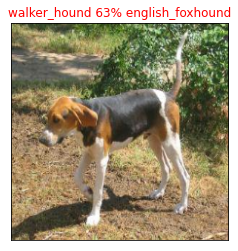

In [95]:
plot_pred(prediction_probabilities=predictions,truth_label=val_labels,images=val_images,n=42)

Viewing the model's top 10 predictions
1. Take an input of prediction probabilities array and a ground truth array and an integer
2. Find the prediction 
3. Find the top 10:
  1. Prediction probabilities indices
  2. Prediction probabilities values
  3. prediction labels

4. Plot the top 10 probability values and labels, colouring the true label green

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n = 1):
  """
  PLot the top 10 highest prediction confidences along with the truth label for sample n.
  """

  pred_prob,true_label = prediction_probabilities[n],labels[n]

  #get the predicted label
  pred_label = get_pred_label(pred_prob)

  #Find the indices of top 10 highest probabilities
  top_10 = pred_prob.argsort()[-10:][::-1]
  #top 10 probabilities
  top_10_conf = pred_prob[top_10]

  # find the top 10 prediction labels
  top_10_labels = unique_breeds[top_10]

  #setup plot
  top_10_plot = plt.bar(np.arange(len(top_10_labels)),top_10_conf,color="grey")
  plt.xticks(np.arange(len(top_10_labels)),labels=top_10_labels,rotation="vertical")

  #change colour of true label
  if np.isin(true_label,top_10_labels):
    top_10_plot[np.argmax(top_10_labels == true_label)].set_color("green")
  else:
    pass


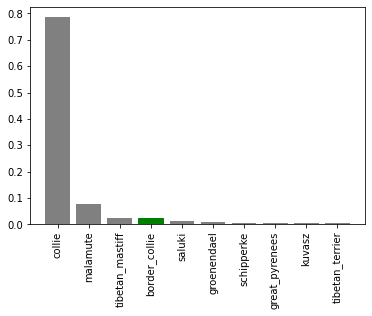

In [97]:
plot_pred_conf(prediction_probabilities=predictions,labels=val_labels,n=9)

Other visualisation tools

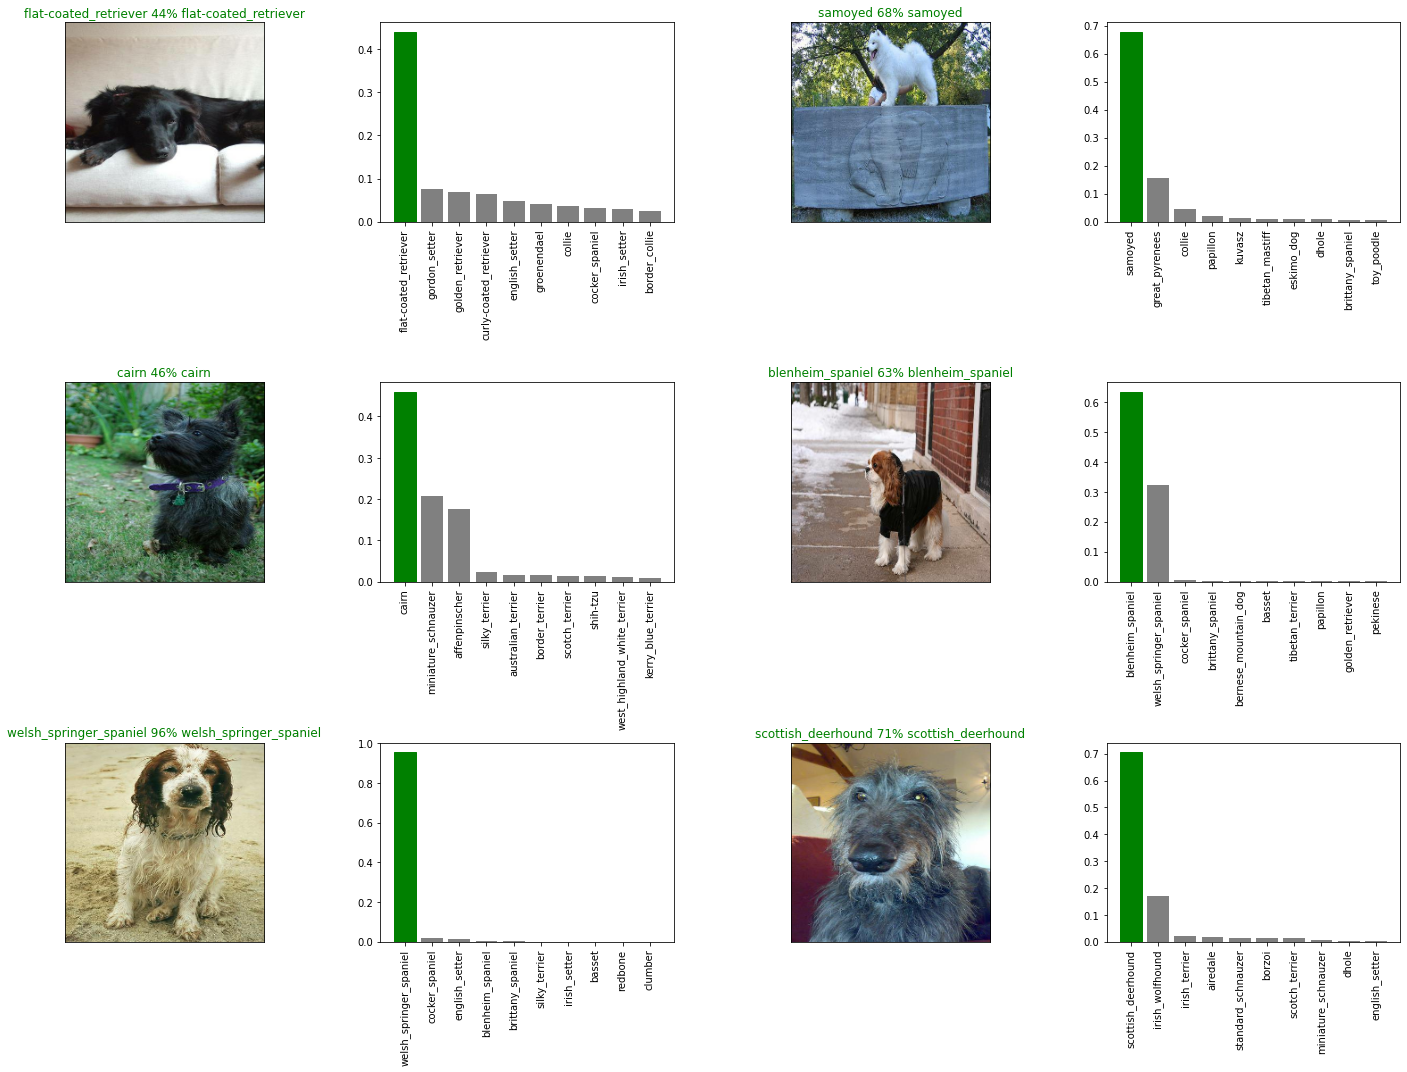

In [98]:
# Few other predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows,2*num_cols,2*i+1)
  plot_pred(prediction_probabilities=predictions,truth_label=val_labels,images=val_images,n=i+i_multiplier)
  plt.subplot(num_rows,2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,labels=val_labels,n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# Saving the model

In [0]:
def save_model(model,suffix=None):
  """
  saves a given a model in model's directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog_vision/models",datetime.datetime.now().strftime("%Y%m%d - %H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5"  #save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [0]:
# load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [101]:
# Saving model trained on 1000 images
save_model(model,suffix="1000_images_mobilenetv2_Adam")

Saving model to: drive/My Drive/Dog_vision/models/20200527 - 08321590568343-1000_images_mobilenetv2_Adam.h5...


'drive/My Drive/Dog_vision/models/20200527 - 08321590568343-1000_images_mobilenetv2_Adam.h5'

In [102]:
# load trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog_vision/models/20200527 - 08321590568343-1000_images_mobilenetv2_Adam.h5')

Loading saved model from: drive/My Drive/Dog_vision/models/20200527 - 08321590568343-1000_images_mobilenetv2_Adam.h5


In [103]:
#Evaluate pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 108ms/step - loss: 1.3100 - accuracy: 0.6650


[1.3099783658981323, 0.6650000214576721]

In [104]:
#Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 115ms/step - loss: 1.3100 - accuracy: 0.6650


[1.3099783658981323, 0.6650000214576721]

# Training the model on full data set

In [105]:
len(X),len(y)

(10222, 10222)

In [106]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)

Creatin training data batches...


In [107]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [108]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
full_model_tensorboard = create_tensorboard_callback()
# no validation set when training on full data, so we cant monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=3)

In [110]:
#fit the full model
full_model.fit(x = full_data,epochs=NUM_EPOCHS,callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 8525s 27s/step - loss: 1.3613 - accuracy: 0.6672
Epoch 2/100
320/320 [==============================] - 47s 147ms/step - loss: 0.4025 - accuracy: 0.8844
Epoch 3/100
320/320 [==============================] - 46s 143ms/step - loss: 0.2369 - accuracy: 0.9352
Epoch 4/100
320/320 [==============================] - 46s 144ms/step - loss: 0.1553 - accuracy: 0.9616
Epoch 5/100
320/320 [==============================] - 46s 145ms/step - loss: 0.1059 - accuracy: 0.9795
Epoch 6/100
320/320 [==============================] - 46s 144ms/step - loss: 0.0798 - accuracy: 0.9852
Epoch 7/100
320/320 [==============================] - 49s 154ms/step - loss: 0.0599 - accuracy: 0.9904
Epoch 8/100
320/320 [==============================] - 50s 157ms/step - loss: 0.0470 - accuracy: 0.9939
Epoch 9/100
320/320 [==============================] - 50s 157ms/step - loss: 0.0393 - accuracy: 0.9955
Epoch 10/100
320/320 [==============================] - 50s 155m

In [111]:
save_model(full_model,suffix="full_image_set_mobilenetv2_adam")

Saving model to: drive/My Drive/Dog_vision/models/20200527 - 11181590578326-full_image_set_mobilenetv2_adam.h5...


'drive/My Drive/Dog_vision/models/20200527 - 11181590578326-full_image_set_mobilenetv2_adam.h5'

In [112]:
loaded_full_model = load_model("drive/My Drive/Dog_vision/models/20200527 - 11181590578326-full_image_set_mobilenetv2_adam.h5")

Loading saved model from: drive/My Drive/Dog_vision/models/20200527 - 11181590578326-full_image_set_mobilenetv2_adam.h5


# Making predictions on the test dataset
The test dataset has to be brought to the same format as that of train dataset

1. Get the test image filenames
2. Convert filenames into test data batches
3. Make predictions array on the test batches

In [114]:
# Load test image filenames
test_path = "drive/My Drive/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/dog-breed-identification/test/f4db24d71e6f3100614eb4543f98394f.jpg',
 'drive/My Drive/dog-breed-identification/test/f157256196b2c6e28a739d2947e956e5.jpg',
 'drive/My Drive/dog-breed-identification/test/f0154b8ea1efd5dfb70e43fada42e56d.jpg',
 'drive/My Drive/dog-breed-identification/test/efc4b489fc15ff97a50536c71029a8b1.jpg',
 'drive/My Drive/dog-breed-identification/test/e91ffd67dd303f59029d041ff4fb65b8.jpg',
 'drive/My Drive/dog-breed-identification/test/f33e9ed93787d73091d1c6f4dabc4c46.jpg',
 'drive/My Drive/dog-breed-identification/test/ec2a07ae6eaa64dac4154584ef229937.jpg',
 'drive/My Drive/dog-breed-identification/test/efa05bbbd2e169dc723df1a43ff0e1bb.jpg',
 'drive/My Drive/dog-breed-identification/test/f372b595f5e684d8c7c261d6b0166736.jpg',
 'drive/My Drive/dog-breed-identification/test/ebe4a8b8507fa28905cb7e70b90b9170.jpg']

In [115]:
# create test data batch
test_data = create_data_batches(test_filenames,test_data=True)

Creating test data batches...


In [116]:
# making predictions on the test data batches using the loaded full model
test_predictions = loaded_full_model.predict(test_data,verbose=1)

324/324 [==============================] - 9560s 30s/step


In [0]:
np.savetxt("drive/My Drive/Dog_vision/preds_array.csv",test_predictions,delimiter=",")

In [0]:
test_predictions = np.loadtxt("drive/My Drive/Dog_vision/preds_array.csv",delimiter=",")

In [119]:
test_predictions[:10]

array([[9.41548728e-10, 6.35787048e-11, 2.88296462e-07, ...,
        2.83177815e-06, 6.53061938e-10, 5.09414111e-09],
       [8.14394738e-08, 3.28208465e-08, 8.47421786e-11, ...,
        5.26992228e-09, 4.17464298e-06, 1.11755803e-02],
       [4.12637206e-07, 5.73057400e-12, 1.15488910e-10, ...,
        4.67254599e-13, 7.07322438e-12, 3.23516179e-11],
       ...,
       [1.38331246e-09, 1.08605667e-08, 1.05986150e-10, ...,
        5.05428455e-09, 1.30898279e-08, 1.12959654e-07],
       [2.95497280e-08, 3.59449182e-08, 8.51540261e-09, ...,
        3.60865493e-09, 2.88173863e-09, 2.25900305e-11],
       [1.38660705e-09, 1.53215840e-08, 5.04127434e-11, ...,
        3.92886765e-11, 1.84527948e-08, 3.60761525e-11]])

In [120]:
test_predictions.shape

(10357, 120)

# Preparing test dataset predictions for kaggle
Prediction probability output as a dataframe with an id and column for all the mentioned dog breeds

In [121]:
# create a pandas dataframe
preds_df = pd.DataFrame(columns=["id"]+list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [0]:
# Appending test image id to predictions dataframe
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [123]:
#Add prediction probabilities
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  f4db24d71e6f3100614eb4543f98394f  ...       5.09414e-09
1  f157256196b2c6e28a739d2947e956e5  ...         0.0111756
2  f0154b8ea1efd5dfb70e43fada42e56d  ...       3.23516e-11
3  efc4b489fc15ff97a50536c71029a8b1  ...       3.88224e-10
4  e91ffd67dd303f59029d041ff4fb65b8  ...       8.13566e-10

[5 rows x 121 columns]

In [0]:
preds_df.to_csv("drive/My Drive/Dog_vision/full_model_prediction_submission_2_mobilenetv2.csv",index=False)

## Making predictions on custom images
1. Get the filepath of the images
2. Turn the filepaths to batches
3. Pass the custom image data batch to our model's `predict()` function
4. Convert prediction output probabilities to predictions labels
5. compare predicted labels to custom images


In [0]:
import os
custom_path = "drive/My Drive/Dog_vision/dog_photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [126]:
custom_data = create_data_batches(custom_image_paths,test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [127]:
custom_preds = loaded_full_model.predict(custom_data)
custom_preds

array([[3.06281436e-08, 2.63041644e-10, 7.15240205e-08, 2.00294926e-05,
        4.95196764e-06, 5.97709573e-07, 9.34882749e-09, 8.54952220e-11,
        3.41839890e-09, 1.31356487e-07, 1.18522543e-07, 1.17540517e-11,
        3.08766701e-08, 1.36845008e-10, 9.29324415e-07, 7.00379246e-07,
        1.02549960e-08, 3.96930426e-03, 2.85144456e-12, 9.44981912e-06,
        8.79153319e-08, 2.90986235e-10, 8.60936211e-08, 5.12239029e-10,
        3.77924567e-11, 1.70298744e-08, 4.36690434e-10, 1.06569473e-07,
        5.11367689e-04, 1.99155693e-07, 4.23938974e-11, 1.73512052e-10,
        1.70166359e-07, 2.23544134e-06, 9.81081248e-05, 5.54283330e-09,
        2.56010102e-09, 1.36412286e-08, 2.30539263e-06, 2.67243061e-10,
        2.16998319e-06, 8.90786487e-06, 4.02983091e-10, 1.73860499e-07,
        9.12357180e-04, 1.47200634e-08, 5.64056757e-09, 8.96508107e-04,
        2.17482704e-03, 2.30823680e-08, 5.31825084e-10, 9.86496070e-06,
        8.84916957e-08, 4.12553600e-05, 2.75599016e-10, 7.461067

In [128]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['labrador_retriever', 'rhodesian_ridgeback', 'redbone']

In [0]:
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

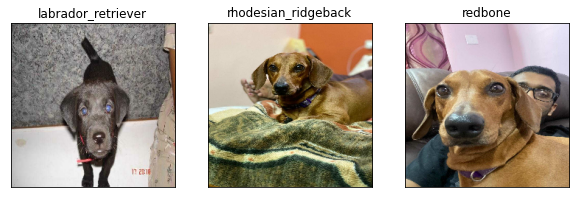

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i,image in enumerate(custom_images):
  plt.subplot(1,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)